### - Transformer based approach from spacy

In [1]:
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
import pandas as pd
import json

In [2]:
nlp = spacy.blank("de") 
db = DocBin()
with open('../annotatedData/annotations_train.json', 'r') as f:
    data_train = json.load(f)

In [3]:
# train and valid split
# actual only reclassification: train and test with the same data

for text, annot in tqdm(data_train['annotations']): # data in previous format
    doc = nlp.make_doc(text) # create doc object from text
    ents = []
    for start, end, label in annot["entities"]: # add character indexes
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    doc.ents = ents # label the text with the ents
    db.add(doc)

db.to_disk("./train.spacy") # save the docbin object



db = DocBin()
with open('../annotatedData/annotations_test.json', 'r') as f:
    data_test = json.load(f)
for text, annot in tqdm(data_test['annotations']): # data in previous format
    doc = nlp.make_doc(text) # create doc object from text
    ents = []
    for start, end, label in annot["entities"]: # add character indexes
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    doc.ents = ents # label the text with the ents
    db.add(doc)

db.to_disk("./valid.spacy") # save the docbin object

100%|██████████| 26/26 [00:00<00:00, 6550.84it/s]


In [ ]:
# only reclassification

# for text, annot in tqdm(data['annotations']): 
#     doc = nlp.make_doc(text) 
#     ents = []
#     for start, end, label in annot["entities"]:
#         span = doc.char_span(start, end, label=label, alignment_mode="contract")
#         if span is None:
#             print("Skipping entity")
#         else:
#             ents.append(span)
#     doc.ents = ents 
#     db.add(doc)

# db.to_disk("./training_data.spacy")

In [4]:
# andere möglichkeit: direkt auf der spacy documentation seite
# cpu ausgewählt für training
! python -m spacy init config config.cfg --lang de --pipeline ner --optimize efficiency

⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: de
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [5]:
! python -m spacy train config.cfg --output ./ --paths.train ./train.spacy --paths.dev ./valid.spacy

ℹ Saving to output directory: .
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2023-08-13 19:53:39,710] [INFO] Set up nlp object from config
[2023-08-13 19:53:39,716] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-08-13 19:53:39,718] [INFO] Created vocabulary
[2023-08-13 19:53:39,718] [INFO] Finished initializing nlp object
[2023-08-13 19:53:39,836] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     69.20    8.95    7.49   11.11    0.09
 21     200        182.58   2663.95   56.36   65.96   49.21    0.56
 47     400         71.33     58.70   57.78   65.66   51.59    0.58
 79     600         95.29     29.06   58.15   65

In [6]:
nlp_ner = spacy.load("model-best") 

In [7]:
# Hinzufügen des Satzsegmentierers zur Pipeline
nlp_ner.add_pipe('sentencizer')

In [8]:
doc = nlp_ner('''Ein Geschäft hat viele Filialen. Jede Filiale darf von höchstens einem Filialleiter
geführt werden. Ein Filialleiter darf höchstens zwei Filialen leiten.
Ohne eine Filiale wird kein Filialleiter bestimmt. Die Filiale bietet viele Produkte
an. Das Produkt wird von vielen Filialen angeboten. Die Filiale beschäftigt viele
Mitarbeiter. Ein Mitarbeiter darf höchstens einen Verkauf bearbeiten. Im Verkauf
können viele Produkte involviert sein. Jedes  Produkt enthält Preis, Produktname und
eindeutige Produkt-ID. Es gibt zwei spezielle Produkttypen: Neuwaren, bei denen
die Verpackungsnummer registriert ist. Bei Gebrauchtwaren wird die Anzahl der
Vorbesitzer mitgeführt. Eine Filiale wird durch die Filial-ID eindeutig identifiziert.
Die Filiale hat einen Filialnamen, eine Filialadresse und eine Telefonnummer. Verkauf enthält
Datum, Uhrzeit und Betrag.
Jeder Mitarbeiter hat einen Mitarbeiternamen bestehend aus Vorname und Nachname, eine oder
mehrere Mitarbeiteradressen und eine Telefonnummer. Die Mitarbeiter und der Filialleiter
werden durch eine ID identifiziert.''')

In [9]:
spacy.displacy.render(doc, style="ent", jupyter=True) # display in Jupyter

In [10]:
def perform_ner(doc): 
    entity_words1 = []

    for sent in doc.sents:
        sent_ner = [(ent.text, ent.label_) for ent in sent.ents]
        print("Satz:", sent.text)
        print("Named Entities:", sent_ner)
        print()

    return entity_words1

entity_words1 = perform_ner(doc)
print(entity_words1)

Satz: Ein Geschäft hat viele Filialen.
Named Entities: [('Ein', 'KARDINALITÄT'), ('Geschäft', 'ENTITÄT'), ('hat', 'BEZIEHUNG'), ('viele', 'KARDINALITÄT'), ('Filialen', 'ENTITÄT')]

Satz: Jede Filiale darf von höchstens einem Filialleiter
geführt werden.
Named Entities: [('Jede', 'KARDINALITÄT'), ('Filiale', 'ENTITÄT'), ('höchstens einem', 'KARDINALITÄT'), ('Filialleiter', 'ENTITÄT'), ('geführt', 'BEZIEHUNG')]

Satz: Ein Filialleiter darf höchstens zwei Filialen leiten.
Named Entities: [('Ein', 'KARDINALITÄT'), ('Filialleiter', 'ENTITÄT'), ('höchstens zwei', 'KARDINALITÄT'), ('Filialen', 'ENTITÄT'), ('leiten', 'BEZIEHUNG')]

Satz: 
Ohne eine Filiale wird kein Filialleiter bestimmt.
Named Entities: [('Filiale', 'ENTITÄT'), ('Filialleiter', 'ENTITÄT')]

Satz: Die Filiale bietet viele Produkte
an.
Named Entities: [('Filiale', 'ENTITÄT'), ('bietet', 'BEZIEHUNG'), ('viele', 'KARDINALITÄT'), ('Produkte', 'ENTITÄT')]

Satz: Das Produkt wird von vielen Filialen angeboten.
Named Entities: [('Pro

In [ ]:
# kein Output, da sonst würde das wieder auf regelbasierten ansatz hinauslaufen mit grammatikstruktur und beziehungen etc.
# daher model_based ansatz geeignet und auch genutzt für Vergleich/Nachschlagewerk für die im regelbasierten gefundenen ER-Komponenten.

### - Confusion Matrix

- problem: spacy support no good evaluation of the model
- solution: workaround--> https://dulaj.medium.com/confusion-matrix-visualization-for-spacy-ner-9e9d99120ee9 

In [11]:
with open('../annotatedData/annotations_test.json', 'r') as f:
    docs_test = json.load(f)

In [12]:
docs = docs_test["annotations"]

In [13]:
from spacy.training import offsets_to_biluo_tags

def get_cleaned_label(label: str):
    if "-" in label:
        return label.split("-")[1]
    else:
        return label
    
def create_total_target_vector(docs):
    target_vector = []
    for doc in docs:
        print (doc)
        new = nlp_ner.make_doc(doc[0])
        entities = doc[1]["entities"]
        bilou_entities = offsets_to_biluo_tags(new, entities)
        final = []
        for item in bilou_entities:
            final.append(get_cleaned_label(item))
        target_vector.extend(final)
    return target_vector

In [14]:
def create_prediction_vector(text):
    return [get_cleaned_label(prediction) for prediction in get_all_ner_predictions(text)]

def create_total_prediction_vector(docs: list):
    prediction_vector = []
    for doc in docs:
        prediction_vector.extend(create_prediction_vector(doc[0]))
    return prediction_vector

def get_all_ner_predictions(text):
    doc = nlp_ner(text)
    entities = [(e.start_char, e.end_char, e.label_) for e in doc.ents]
    bilou_entities = offsets_to_biluo_tags(doc, entities)
    return bilou_entities

In [15]:
def get_model_labels():
    labels = list(nlp_ner.get_pipe("ner").labels)
    labels.append("O")
    return sorted(labels)
def get_dataset_labels():
    return sorted(set(create_total_target_vector(docs)))

In [16]:
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix(docs): 
    classes = sorted(set(create_total_target_vector(docs)))
    y_true = create_total_target_vector(docs)
    y_pred = create_total_prediction_vector(docs)
    print (y_true)
    print (y_pred)
    return confusion_matrix(y_true, y_pred, labels=classes)

In [17]:
from matplotlib import pyplot
import numpy

def plot_confusion_matrix(docs, classes, normalize=False, cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   
    title = 'Confusion Matrix, for SpaCy NER'

    # Compute confusion matrix
    cm = generate_confusion_matrix(docs)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

    fig, ax = pyplot.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=numpy.arange(cm.shape[1]),
           yticks=numpy.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    pyplot.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm, ax, pyplot

['Ein Automobilkonzern besitzt mehrere Marken. ', {'entities': [[0, 3, 'KARDINALITÄT'], [4, 20, 'ENTITÄT'], [21, 28, 'BEZIEHUNG'], [29, 36, 'KARDINALITÄT'], [37, 43, 'ENTITÄT']]}]
['Eine Marke wird über die Markennummer eindeutig identifiziert. ', {'entities': [[5, 10, 'ENTITÄT'], [26, 38, 'PRIMÄRSCHLÜSSEL']]}]
['Ein Automobilkonzern beschäftigt mehrere Beraterfirmen. ', {'entities': [[0, 3, 'KARDINALITÄT'], [4, 20, 'ENTITÄT'], [21, 33, 'BEZIEHUNG'], [34, 41, 'KARDINALITÄT'], [42, 55, 'ENTITÄT']]}]
['Eine Beraterfirma kann bei mehreren Automobilkonzernen beschäftigt sein.', {'entities': [[0, 4, 'KARDINALITÄT'], [5, 17, 'ENTITÄT'], [27, 35, 'KARDINALITÄT'], [36, 54, 'ENTITÄT'], [55, 67, 'BEZIEHUNG']]}]
['Eine Autovermietung besitzt viele verschiedene Automodelle. ', {'entities': [[0, 4, 'KARDINALITÄT'], [5, 19, 'ENTITÄT'], [20, 27, 'BEZIEHUNG'], [28, 33, 'KARDINALITÄT'], [47, 58, 'ENTITÄT']]}]
['Jedes Automodell kann durch das Schlüsselattribut „Modellnummer“ eindeutig identifiziert

(array([[  6,   0,   0,   0,   0,   0,   1,   0],
        [  0,   7,   0,   0,   0,   0,  17,   0],
        [  1,   0,  40,   2,   0,   0,   8,   0],
        [  0,   0,   2,   0,   0,   0,   0,   0],
        [  1,   1,   1,   0,  31,   0,  17,   0],
        [  0,   0,   1,   0,   0,   0,   0,   0],
        [  2,   3,   1,   1,   6,   0, 153,   0],
        [  3,   0,   1,   0,   0,   0,   3,   4]]),
 <Axes: title={'center': 'Confusion Matrix, for SpaCy NER'}, xlabel='Predicted label', ylabel='True label'>,
 <module 'matplotlib.pyplot' from '/Users/vaihunthanvyramuthu/opt/anaconda3/envs/projektarbeit/lib/python3.10/site-packages/matplotlib/pyplot.py'>)

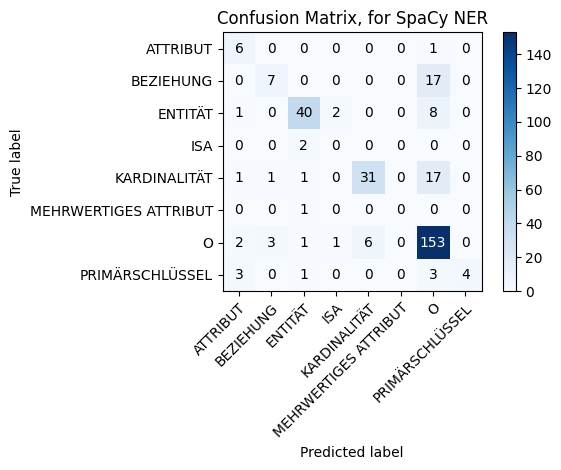

In [18]:
plot_confusion_matrix(docs,classes=get_dataset_labels(),normalize=False)